In [65]:
import pandas as pd
import numpy as np
from sklearn.metrics import confusion_matrix
import scipy.stats as stats

# Optimisation
from pymoo.model.repair import Repair
from pymoo.model.problem import Problem
from pymoo.optimize import minimize
from pymoo.algorithms.nsga2 import NSGA2
from pymoo.factory import *
from pymoo.model.sampling import Sampling



In [193]:
df = pd.read_csv("../input/mailguard-labeled-results.csv")

inputs = {
    "id_column": "mid",
    "ground_truth_column": "ground_truth",
    "reject_label": "REJECT",
    "min": 0,
    "max": 1,
    
    "probability_column" : "probabilities",  # Optional???
    "target_label" : "spam",                 # Optional???
    
}

In [6]:
df = pd.read_csv("../input/predictions-email-classifier-percept_20191014-161825.csv")
inputs = {
    "id_column": "email_id",
    "ground_truth_column": "work_type",
    "reject_label": "REJECT",
    "min": 0,
    "max": 100
}

# Core functions

In [194]:
def calculate_matches(x, lower, upper):
    not_match = np.less(x, lower)
    match = np.greater_equal(x, upper)
    rejects = ~np.logical_xor(not_match, match)
    return np.stack([not_match, match, rejects])

def apply_thresholds(probabilities, lower, upper):
    temp = calculate_matches(probabilities, lower, upper)
    def value(x):
        return np.where(x == True)[0][0]
    return np.apply_along_axis(value, 0, temp)
 
def calculate_confusion_matrices(gt, pred):
    result = np.zeros((gt.shape[1],3,3), dtype=np.int)
    for i,(x,y) in enumerate(zip(gt.T,pred.T)):
        matrix = confusion_matrix(x,y)
        if np.shape(matrix) < (3,3):
            matrix = np.c_[matrix, np.zeros(2)]
            matrix = np.r_[matrix, [np.zeros(3)]]
        elif np.shape(matrix) > (3, 3):
            raise ValueError("Matrix should be 3x3, error in input labels")

        # Column order: matches, not match, rejects
        matrix[:,[0,1]] = matrix[:,[1, 0]]
        # Row order: matches, not match, rejects 
        matrix[[0,1], :] = matrix[[1, 0], :]

        result[i] = matrix
    return result

def normalise_probs_in_place(df, inputs, labels):
    if inputs["min"] == 0 and inputs["max"] == 100:
        for label in labels:
            if label == inputs["reject_label"]:
                continue
            if (df[label] < 1).any() and (df[label] >= 0).any():
                return 
            df[label] = df[label] / 100      
    elif inputs["min"] == 0 and inputs["max"] == 1:
        # TODO: Check that the provided constraints are not violated 
        return
    else:
        raise ValueError("Normalisation rule not specified")

def derive_probabilities(df, inputs):
    if "probability_column" in inputs:
        probabilities = pd.DataFrame()
        probabilities[inputs["target_label"]] = df[inputs["probability_column"]]
        probabilities["id"] = df[inputs["id_column"]]
    else:
        labels = list(retrieve_labels(df, inputs))
        labels.insert(0, inputs["id_column"])
        probabilities = df[labels]
        probabilities = probabilities.rename(columns={inputs["id_column"]: "id"})
    return probabilities.drop_duplicates("id")

def retrieve_labels(df, inputs):
    return df[inputs["ground_truth_column"]].str.strip().sort_values().unique()

def check_labels_have_columns(df, labels):
    return len(set(df.columns) & set(labels)) == len(labels)

def prepare_labels(df, inputs):
    labels = retrieve_labels(df, inputs)

    if "target_label" in inputs:
        labels = list(filter(lambda x: x == inputs["target_label"], labels))
    
    if not check_labels_have_columns(df, labels) and not "probability_column" in inputs:
        raise ValueError("Labels do not have column names for probabilities")   
        
    return sorted(labels)


def prepare_ground_truth(df, inputs, mapping):
    ids = []
    truth_columns = inputs["ground_truth_column"]

    if not "target_label" in inputs:
        all_labels = []
        for a_id in df[inputs["id_column"]].unique():
            ground_truth_labels = df[df[inputs["id_column"]] == a_id][truth_columns]
            indexes = [mapping[s.strip()] for s in list(ground_truth_labels)]     
            ground_truth = np.zeros(len(mapping), dtype=int)
            ground_truth[indexes] = 1
            ids.append(a_id)
            all_labels.append(ground_truth)
        columns = list(mapping.keys())
        ground_truth = pd.DataFrame(all_labels)
        ground_truth.columns = columns
    else:
        ids = df[inputs["id_column"]].unique()
        ground_truth = pd.DataFrame()
        ground_truth[inputs["target_label"]] = (df[truth_columns] == inputs["target_label"]) * 1
    ground_truth["id"] = ids    
    return ground_truth


def get_objective(probabilities, ground_truth, lower_thresholds, upper_thresholds):
    """
    returns: (all confusion matrices, thresholds) 
    """
    thres = apply_thresholds(probabilities, lower_thresholds, upper_thresholds)  
    all_results = calculate_confusion_matrices(ground_truth, thres)
    return all_results, thres

def summarise_results(all_results):
    """
    returns Summary array of true match, 
    false match, missed match, and rejects, 
    """
    return np.array([all_results[:,0][:,0].sum(),
            all_results[:,1][:,0].sum(),
            all_results[:,0][:,1].sum(),
            all_results[:,:,2].sum()])

# Usage guide 

In [195]:
labels = prepare_labels(df, inputs)

# Probabilities
normalise_probs_in_place(df, inputs, labels)
probabilities = derive_probabilities(df, inputs)

# Ground truth
mapping = {label: i for i, label in enumerate(labels)}
ground_truth = prepare_ground_truth(df, inputs, mapping)

np_probs = probabilities[labels].to_numpy()    
np_ground_truth = ground_truth[labels].to_numpy()

In [196]:
new_threshold = np.full(10, 0.51, dtype=np.double)

# True match, false match, missed match, rejects
all_matrices, thresholded = get_objective(np_probs, np_ground_truth, new_threshold, new_threshold)
all_matrices

array([[[32.0, 19.0, 0.0],
        [1.0, 48.0, 0.0],
        [0.0, 0.0, 0.0]]], dtype=object)

In [197]:
summarise_results(all_matrices)

array([32.,  1., 19.,  0.])

# Cost calculations

In [198]:
params = {
  "cost": {
    "matrix" : [[50,500, 50],[5000,50,50], [0,0,0]],
    "portion_size" : 1000,
    "estimate_size":10000    # Estimate the cost for classifying N # of items
  }
}

def calculate_cost(predicted_matrix, cost_weights, portion_size, estimate_size):
    cost_per_prediction = np.array(cost_weights) / portion_size
    scaled_matrix = np.round(predicted_matrix.astype(np.double) / predicted_matrix.sum() * estimate_size)
    return scaled_matrix * cost_per_prediction

# Usage guide
calculate_cost(all_matrices[0], params["cost"]["matrix"], params["cost"]["portion_size"], params["cost"]["estimate_size"])

array([[160., 950.,   0.],
       [500., 240.,   0.],
       [  0.,   0.,   0.]])

In [199]:
def calculate_all_costs(all_matrices, cost_weights, portion_size, estimate_size):
    cost_results = np.zeros((len(all_matrices), 3, 3))
    for i, a in enumerate(all_matrices):
        cost_results[i] = calculate_cost(a, cost_weights, portion_size, estimate_size)
    return cost_results

# Usage guide
all_costs = calculate_all_costs(all_matrices, params["cost"]["matrix"], params["cost"]["portion_size"], params["cost"]["estimate_size"])
all_costs

array([[[160., 950.,   0.],
        [500., 240.,   0.],
        [  0.,   0.,   0.]]])

In [200]:
summarise_results(all_costs)

array([160., 500., 950.,   0.])

# Auto-Recommender

In [201]:
class MyRepair(Repair):

    def _do(self, problem, pop, **kwargs):
        for i in range(len(pop)):
            x = pop[i].X
            pop[i].X = np.around(x, decimals=2)
        return pop

class FindThresholds(Problem):
    def __init__(self, probabilities, ground_truth, **kwargs):
        self.probabilities = probabilities     
        self.ground_truth = ground_truth
        n_var = probabilities.shape[1]
        super().__init__(n_var=n_var, 
                         n_constr=0, 
                         n_obj=4, 
                         xl=anp.zeros((n_var,), dtype=anp.int), 
                         xu=anp.ones((n_var,), dtype=anp.int),  
                         type_var=anp.int, 
                         elementwise_evaluation=True)
    
    def _evaluate(self, X, out, *args, **kwargs):
        f0 = []
        f1 = []
        f2 = []
        f3 = []
        thresholds = X 
        all_matrices, thresholded = get_objective(self.probabilities, self.ground_truth, thresholds, thresholds)
        
# TODO: Trial optimisin        
#        all_matrices = calculate_all_costs(all_matrices, params["cost"]["matrix"], params["cost"]["portion_size"], params["cost"]["estimate_size"])
        
        true_matches, false_matches, missed_matches, rejects = summarise_results(all_matrices)
        
        f0.append(true_matches * -1)   # True matches need to be maximised, pymoo only minimises
        f1.append(false_matches)
        f2.append(missed_matches)
        f3.append(rejects)
            
        out["F"] = anp.column_stack([f0, f1, f2, f3]).astype(anp.double)
        


In [202]:
class BetaDistribution(Sampling):

    def __init__(self):
        super().__init__()

    def _do(self, problem, n_samples, **kwargs):        
        return stats.beta(a=4, b=2).rvs(size=(n_samples, problem.n_var))
    
algorithm = NSGA2(
    pop_size=40,
    n_offsprings=10,
    repair=MyRepair(),
    sampling= BetaDistribution(), #get_sampling("int_lhs"),
    crossover=get_crossover("real_sbx", prob=0.9, eta=15),
    mutation=get_mutation("real_pm", eta=20),
)    

problem = FindThresholds(np_probs, np_ground_truth, parallelizable=("threads", 4))

In [203]:
import timeit

results = None

def value():
    global results
    results = minimize(problem,
               algorithm,
               ("n_gen", 10),
               save_history=True,
               verbose=True)
timeit.timeit(value,number=1)

n_gen | n_eval 
1     | 40     
2     | 50     
3     | 60     
4     | 70     
5     | 80     
6     | 90     
7     | 100    
8     | 110    
9     | 120    
10    | 130    


0.22319131399945036

In [204]:
F = results.F

weights = np.array([0.5,0.25,0.25,0])
I = get_decomposition("weighted-sum").do(F, weights).argmin()
print("Best regarding decomposition: Point %s - %s, %s" % (I, F[I], results.X[I]))

a = F[I]
a, a[0] * -1 + a[1:].sum() * -3

Best regarding decomposition: Point 3 - [-38.   4.  13.   0.], [0.18]


(array([-38.,   4.,  13.,   0.]), -13.0)

In [205]:
a = summarise_results(all_matrices)
a, a[0] + a[1:].sum() * -3

(array([32.,  1., 19.,  0.]), -28.0)

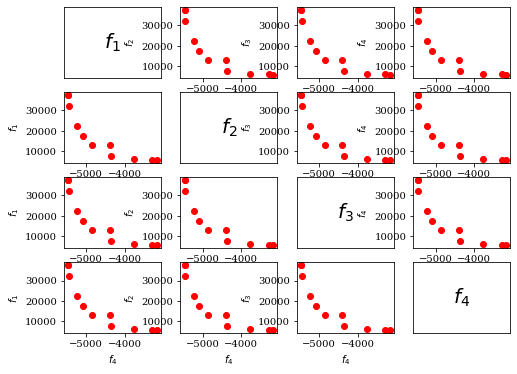

In [272]:
from pymoo.visualization.scatter import Scatter
import matplotlib.pyplot as plt
plot = Scatter()
plot.add(problem.pareto_front(), plot_type="line", color="black", alpha=0.7)
plot.add(results.F, color="red")
plot.show()
plt.show()

In [206]:
results.F

array([[-51.,  47.,   0.,   0.],
       [ -0.,   0.,  51.,   0.],
       [-32.,   1.,  19.,   0.],
       [-38.,   4.,  13.,   0.],
       [-45.,  33.,   6.,   0.],
       [-35.,   3.,  16.,   0.],
       [-47.,  39.,   4.,   0.],
       [-49.,  41.,   2.,   0.],
       [-46.,  34.,   5.,   0.],
       [-50.,  44.,   1.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-35.,   3.,  16.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-35.,   3.,  16.,   0.],
       [-35.,   3.,  16.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-32.,   1.,  19.,   0.],
       [-35.,   3.,  16.,   0.],
       [-3

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x12a772a50>]],
      dtype=object)

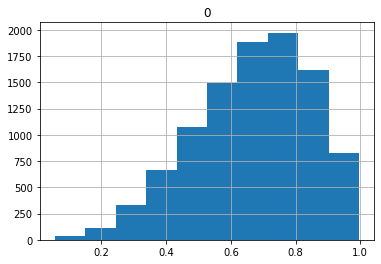

In [208]:
pd.DataFrame(stats.beta(a=4, b=2).rvs(size=10000)).hist()